In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow_datasets.text import IMDBReviews

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(tf.__version__)

2.8.0


Загрузим датасет с ценами на жилье в Бостоне

In [20]:
X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=42)

train_df = pd.DataFrame(X_train, columns=load_boston().feature_names)
test_df = pd.DataFrame(X_test, columns=load_boston().feature_names)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     354 non-null    float64
 1   ZN       354 non-null    float64
 2   INDUS    354 non-null    float64
 3   CHAS     354 non-null    float64
 4   NOX      354 non-null    float64
 5   RM       354 non-null    float64
 6   AGE      354 non-null    float64
 7   DIS      354 non-null    float64
 8   RAD      354 non-null    float64
 9   TAX      354 non-null    float64
 10  PTRATIO  354 non-null    float64
 11  B        354 non-null    float64
 12  LSTAT    354 non-null    float64
dtypes: float64(13)
memory usage: 36.1 KB


In [22]:
train_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,3.469887,11.403955,11.133051,0.073446,0.557259,6.325672,68.799718,3.765874,9.437853,407.042373,18.277966,359.701808,12.421130
std,8.315831,22.608457,6.938651,0.261237,0.116792,0.719211,27.665360,2.126032,8.639971,166.522237,2.256792,86.924779,7.112402
min,0.009060,0.000000,1.210000,0.000000,0.385000,3.863000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082320,0.000000,5.130000,0.000000,0.450000,5.889500,46.025000,2.073700,4.000000,279.000000,16.650000,376.782500,6.862500
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.227500,77.350000,3.107300,5.000000,330.000000,18.600000,391.600000,10.925000
75%,3.281688,20.000000,18.100000,0.000000,0.631000,6.681750,93.475000,5.400700,24.000000,666.000000,20.200000,396.172500,16.225000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [23]:
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [24]:
cont_transformers = []
cont_columns = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']

cat_transformers = []
cat_columns = ['CHAS']

for col in cont_columns:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=col)),
                ('standard', StandardScaler())
            ])
    cont_transformers.append((col, transfomer))

for col in cat_columns:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=col)),
            ])
    cat_transformers.append((col, transfomer))

feats = FeatureUnion(cont_transformers+cat_transformers)

In [25]:
X_train = feats.fit_transform(train_df)
X_test = feats.transform(test_df)

В качестве baseline построим сеть с двумя внутренними слоями и линейной активацией.

In [26]:
model = Sequential([
                    Dense(32, activation='linear', input_shape=(13,)),
                    Dense(16, activation='linear'),
                    Dense(1, activation='linear')
                    ])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                448       
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)))

Оценим качество модели

In [28]:
# if tf.config.experimental.list_physical_devices("GPU"):
#   with tf.device("GPU:0"): 
h = model.fit(X_train, y_train, epochs=30, validation_split=0.15, verbose=0)
test_loss, test_r2 = model.evaluate(X_test, y_test, verbose=0)
print(f'R2 на трейне - {h.history.get("r_square")[-1]:.6f};\n'
      f'R2 на валидационном сете - {h.history.get("val_r_square")[-1]:.6f};\n'
      f'R2 на тесте - {test_r2:6f}.')

R2 на трейне - 0.639128;
R2 на валидационном сете - 0.491716;
R2 на тесте - 0.550215.


Улучшим модель

In [29]:
def eval_model(X_train, y_train, epoch, val_split=0.15):
  # if tf.config.experimental.list_physical_devices("GPU"):
      # with tf.device("GPU:0"): 
        h = model.fit(X_train, y_train, epochs=epoch, validation_split=0.15, verbose=0)
        test_loss, test_r2 = model.evaluate(X_test, y_test, verbose=0)
        print(f'\tR2 на трейне - {h.history.get("r_square")[-1]:.6f};\n'
              f'\tR2 на валидационном сете - {h.history.get("val_r_square")[-1]:.6f};\n'
              f'\tR2 на тесте - {test_r2:6f}.')

In [30]:
neurons  = [64, 128, 256, 512]
epochs = [30, 50, 100, 200]

for neuron in neurons:
  for epoch in epochs:
    model = Sequential([Dense(neuron, activation='linear', input_shape=(13,)),
                        Dense(int(neuron/2), activation='linear'),
                        Dense(1, activation='linear')])
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)))
    
    print(f'Количество нейронов в первом внутреннем слое - {neuron}, '
          f'Количество эпох - {epoch}:')

    eval_model(X_train, y_train, epoch)

Количество нейронов в первом внутреннем слое - 64, Количество эпох - 30:
	R2 на трейне - 0.744873;
	R2 на валидационном сете - 0.596119;
	R2 на тесте - 0.648429.
Количество нейронов в первом внутреннем слое - 64, Количество эпох - 50:
	R2 на трейне - 0.745456;
	R2 на валидационном сете - 0.589604;
	R2 на тесте - 0.705260.
Количество нейронов в первом внутреннем слое - 64, Количество эпох - 100:
	R2 на трейне - 0.749046;
	R2 на валидационном сете - 0.532783;
	R2 на тесте - 0.653038.
Количество нейронов в первом внутреннем слое - 64, Количество эпох - 200:
	R2 на трейне - 0.744308;
	R2 на валидационном сете - 0.574423;
	R2 на тесте - 0.692978.
Количество нейронов в первом внутреннем слое - 128, Количество эпох - 30:
	R2 на трейне - 0.738318;
	R2 на валидационном сете - 0.515714;
	R2 на тесте - 0.639355.
Количество нейронов в первом внутреннем слое - 128, Количество эпох - 50:
	R2 на трейне - 0.730102;
	R2 на валидационном сете - 0.578153;
	R2 на тесте - 0.685682.
Количество нейронов в пе

Попробуем разные оптимизаторы

In [31]:
for optim in ['SGD', 'RMSProp','adam','NAdam']:
    model = Sequential([Dense(256, activation='linear', input_shape=(13,)),
                        Dense(128, activation='linear'),
                        Dense(1, activation='linear')])
    
    model.compile(optimizer=optim,
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)))

    print(f'Оптимайзер {optim}:')

    eval_model(X_train, y_train, epoch=100)

Оптимайзер SGD:
	R2 на трейне - nan;
	R2 на валидационном сете - nan;
	R2 на тесте -    nan.
Оптимайзер RMSProp:
	R2 на трейне - 0.718141;
	R2 на валидационном сете - 0.613700;
	R2 на тесте - 0.701798.
Оптимайзер adam:
	R2 на трейне - 0.738798;
	R2 на валидационном сете - 0.557362;
	R2 на тесте - 0.693808.
Оптимайзер NAdam:
	R2 на трейне - 0.746273;
	R2 на валидационном сете - 0.571805;
	R2 на тесте - 0.688487.


Попробуем использовать другую функцию активации и уменьшить скорость обучения:

In [32]:
tf.random.set_seed(42)

lr = 1e-3

for optim in [tf.keras.optimizers.SGD(learning_rate=lr),
              tf.keras.optimizers.RMSprop(learning_rate=lr),
              tf.keras.optimizers.Adam(learning_rate=lr),
              tf.keras.optimizers.Nadam(learning_rate=lr)]:

  model = Sequential([Dense(256, activation='relu', input_shape=(13,)),
                      Dense(128, activation='relu'),
                      Dense(1, activation='relu')])
    
  model.compile(optimizer=optim,
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)))

  print(f'Оптимайзер {type(optim).__name__}:')

  eval_model(X_train, y_train, epoch=100)

Оптимайзер SGD:
	R2 на трейне - 0.937159;
	R2 на валидационном сете - 0.778601;
	R2 на тесте - 0.855621.
Оптимайзер RMSprop:
	R2 на трейне - 0.961459;
	R2 на валидационном сете - 0.778355;
	R2 на тесте - 0.848614.
Оптимайзер Adam:
	R2 на трейне - 0.949565;
	R2 на валидационном сете - 0.791297;
	R2 на тесте - 0.856570.
Оптимайзер Nadam:
	R2 на трейне - 0.956556;
	R2 на валидационном сете - 0.800594;
	R2 на тесте - 0.856984.


Метрики улучшились, но есть разрыв на трейне и валидации. Попробуем добавить слои в модель и поменять скорость обучения

	R2 на трейне - 0.949407;
	R2 на валидационном сете - 0.860456;
	R2 на тесте - 0.891092.


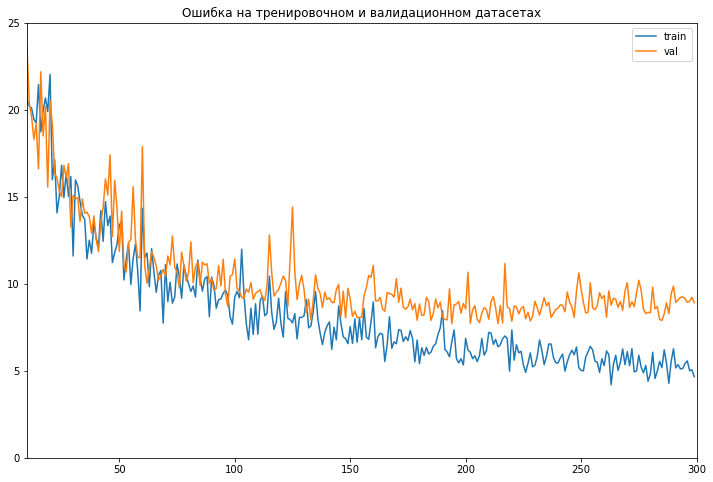

In [33]:
tf.random.set_seed(42)

lr = 3e-4

def eval_model(X_train, y_train, epoch, val_split=0.15):
  # if tf.config.experimental.list_physical_devices("GPU"):
      # with tf.device("GPU:0"): 
        h = model.fit(X_train, y_train, epochs=epoch, validation_split=0.15, 
                      batch_size=10, verbose=0)
        test_loss, test_r2 = model.evaluate(X_test, y_test, verbose=0)
        print(f'\tR2 на трейне - {h.history.get("r_square")[-1]:.6f};\n'
              f'\tR2 на валидационном сете - {h.history.get("val_r_square")[-1]:.6f};\n'
              f'\tR2 на тесте - {test_r2:6f}.')
        return h
        
# Добавим в модель дропаут слои, чтобы уменьшить переобучение

model = Sequential([Dense(256, activation='relu', input_shape=(13,)),
                    Dropout(0.2),
                    Dense(192, activation='relu'),
                    Dropout(0.2),
                    Dense(128, activation='linear'),
                    Dropout(0.2),
                    Dense(64, activation='relu'),
                    Dropout(0.1),
                    Dense(32, activation='linear'),
                    Dense(1, activation='relu')])

    
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,)))

h = eval_model(X_train, y_train, epoch=300)


plt.figure(figsize=(12, 8))
plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='val')
plt.xlim([10, 300])
plt.ylim([0, 25])
plt.title('Ошибка на тренировочном и валидационном датасетах')
plt.legend()
plt.show()

В результате донастройки удалось поднять метрику до 0.89. Помогло увеличение слоёв, количества нейронов и эпох обучения.Так же очень помогло изменение функции активации на relu